#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Требуется построить модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

В рамках поставленной задачи необходимо:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные находятся в файле `taxi.csv`. Количество заказов находится в столбце `num_orders`.

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Анализ-данных" data-toc-modified-id="Анализ-данных-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ данных</a></span><ul class="toc-item"><li><span><a href="#Вывод" data-toc-modified-id="Вывод-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Вывод</a></span></li></ul></li><li><span><a href="#Обучение-моделей" data-toc-modified-id="Обучение-моделей-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение моделей</a></span><ul class="toc-item"><li><span><a href="#Работа-с-LinearRegression" data-toc-modified-id="Работа-с-LinearRegression-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Работа с LinearRegression</a></span></li><li><span><a href="#Работа-с-RandomForestRegressor" data-toc-modified-id="Работа-с-RandomForestRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Работа с RandomForestRegressor</a></span></li><li><span><a href="#Работа-с-DecisionTreeRegressor" data-toc-modified-id="Работа-с-DecisionTreeRegressor-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Работа с DecisionTreeRegressor</a></span></li><li><span><a href="#Работа-с-LightGBM" data-toc-modified-id="Работа-с-LightGBM-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Работа с LightGBM</a></span></li></ul></li><li><span><a href="#Тестирование-моделей" data-toc-modified-id="Тестирование-моделей-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование моделей</a></span><ul class="toc-item"><li><span><a href="#Тест-LinearRegression" data-toc-modified-id="Тест-LinearRegression-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Тест LinearRegression</a></span></li><li><span><a href="#Тест-RandomForestRegressor" data-toc-modified-id="Тест-RandomForestRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Тест RandomForestRegressor</a></span></li><li><span><a href="#Тест-DecisionTreeRegressor" data-toc-modified-id="Тест-DecisionTreeRegressor-4.3"><span class="toc-item-num">4.3&nbsp;&nbsp;</span>Тест DecisionTreeRegressor</a></span></li><li><span><a href="#Тест-LightGBM" data-toc-modified-id="Тест-LightGBM-4.4"><span class="toc-item-num">4.4&nbsp;&nbsp;</span>Тест LightGBM</a></span></li></ul></li><li><span><a href="#Вывод" data-toc-modified-id="Вывод-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Вывод</a></span></li></ul></div>

## Подготовка данных

In [82]:
# импорт необходимых библиотек для работы
import pandas as pd
import numpy as np
import warnings
import math
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
from lightgbm import LGBMRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [83]:
# убираем отображение лишних ошибок
warnings.filterwarnings('ignore')

In [84]:
# убираем границы для просмотра датасета
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [85]:
# загружаем данные с закреплением индекса за 0 столбцом и загружаем 0 столбец в качестве даты/времени
def reopen_dataset():
    try:
        data = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
    except:
        data = pd.read_csv('C:/Users/fokin/OneDrive/Рабочий стол/Дата Сайнс/Анализ временных рядов/Проект/taxi.csv', index_col=[0], parse_dates=[0])
    
    data.sort_index(inplace=True)
    return data
    
data = reopen_dataset()

In [86]:
# обзор датасета
display(data.info())
display(data.describe())
display(data.columns)
display(data.head(10))
display(data.tail(10))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


Index(['num_orders'], dtype='object')

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


,num_orders
datetime,
2018-08-31 22:20:00,48
2018-08-31 22:30:00,41
2018-08-31 22:40:00,34
2018-08-31 22:50:00,34
2018-08-31 23:00:00,30
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39


In [87]:
# вычислим общее количество заказов
print('Количество заказов', data['num_orders'].sum())

Количество заказов 372811


In [88]:
# смотрим дублирующие строки, дублирование по дате не критично
display(data.duplicated().sum())
display(data.duplicated().head(10))

26415

datetime
2018-03-01 00:00:00    False
2018-03-01 00:10:00    False
2018-03-01 00:20:00    False
2018-03-01 00:30:00    False
2018-03-01 00:40:00    False
2018-03-01 00:50:00    False
2018-03-01 01:00:00    False
2018-03-01 01:10:00    False
2018-03-01 01:20:00    False
2018-03-01 01:30:00    False
dtype: bool

In [89]:
# проверка наличия пустых/нулевых строк
display(data.isna().sum())
display(data.isnull().sum())

num_orders    0
dtype: int64

num_orders    0
dtype: int64

In [90]:
# в хронологическом порядке ли расположены даты и время
display(data.index.is_monotonic)

True

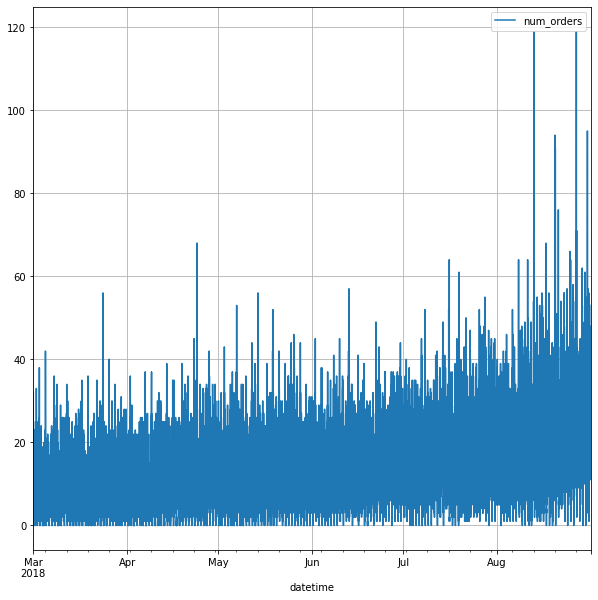

In [91]:
# данные до ресемплирования
data.plot(figsize=(10,10), grid=True)
plt.show()

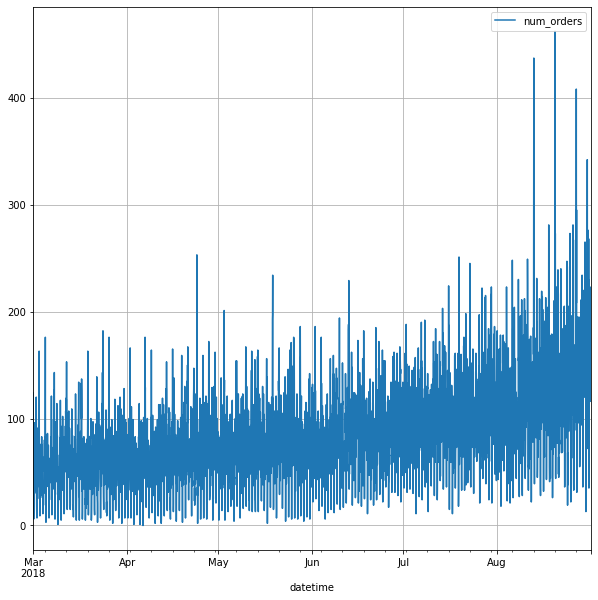

In [92]:
# выполним ресемплирование по 1 часу с агрегацией по сумме, убедимся, что данные идентичны
data = data.resample('1H').sum()
data.plot(figsize=(10,10), grid=True)
plt.show()

In [93]:
# отобрази результат изменения
display(data.info())
display(data.describe())
display(data.head(40))

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


None

,num_orders
count,4416.000000
mean,84.422781
std,45.023853
min,0.000000
25%,54.000000
50%,78.000000
75%,107.000000
max,462.000000


,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43
2018-03-01 05:00:00,6
2018-03-01 06:00:00,12
2018-03-01 07:00:00,15
2018-03-01 08:00:00,34


### Вывод

На этапе подготовки датасета данные были загружены и преобразованы во временной ряд для дальнейшей работы. Мы имеем временной ряд с 01.03.2018г. по 31.08.2018г., в совокупности период составляет 6 месяцев. За этот период получено 372811 заказов. По итогам ресемплирования получили ряд с понятным растущим трендом, но при этом сезонность данного ряда по столь короткому отрезку времени определить не представляется возможным.

## Анализ данных

In [94]:
# создадим датасет для анализа
analysis = data

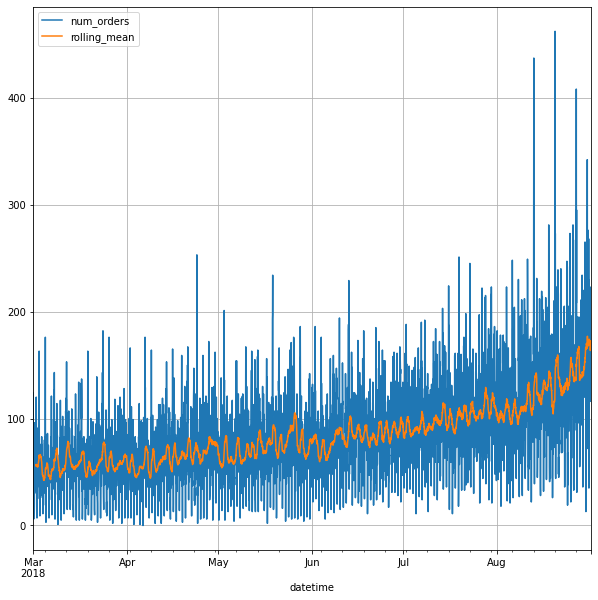

In [95]:
# добавим скользящее среднее с размером окна 24
analysis['rolling_mean'] = analysis.rolling(24).mean()
analysis.plot(figsize=(10,10), grid=True)
plt.show()

In [96]:
# уберем пока лишний столбец
analysis = analysis.drop('rolling_mean', axis=1)

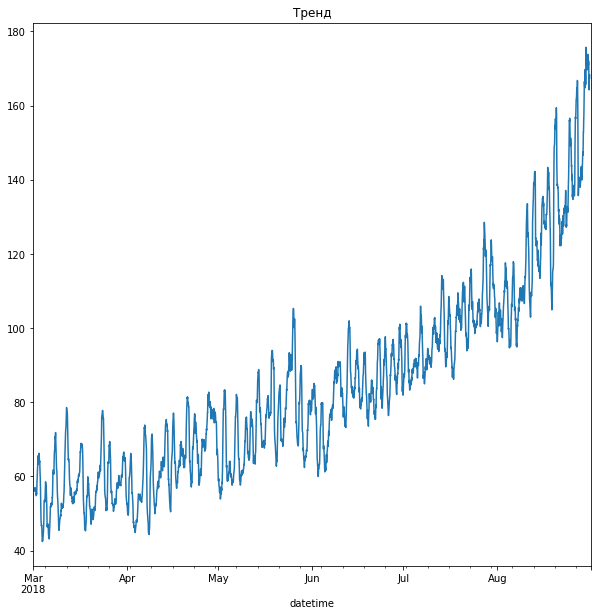

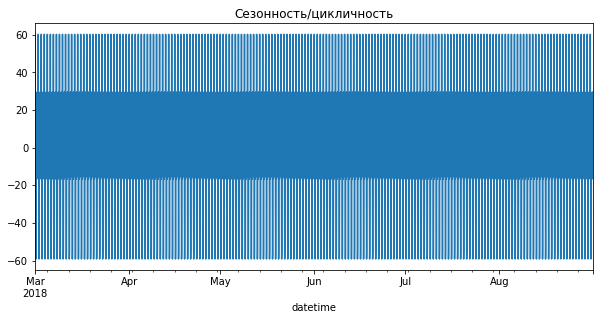

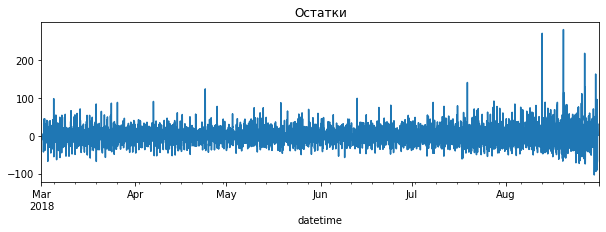

In [97]:
# разложим ряд на три составляющие: тренд, сезонность, остаток

decomposed = seasonal_decompose(analysis)

plt.subplot(111)
decomposed.trend.plot(ax=plt.gca(), figsize=(10,10))
plt.title('Тренд')
plt.show()
plt.subplot(211)
decomposed.seasonal.plot(ax=plt.gca(), figsize=(10,10))
plt.title('Сезонность/цикличность')
plt.show()
plt.subplot(311)
decomposed.resid.plot(ax=plt.gca(), figsize=(10,10))
plt.title('Остатки')
plt.show()

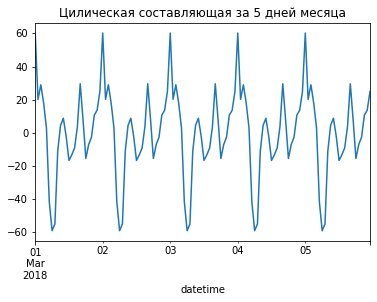

In [98]:
# вычленим циклическую составляющую
decomposed.seasonal['2018-03-01':'2018-03-5'].plot(ax=plt.gca())
plt.title('Цилическая составляющая за 5 дней месяца')
plt.show()

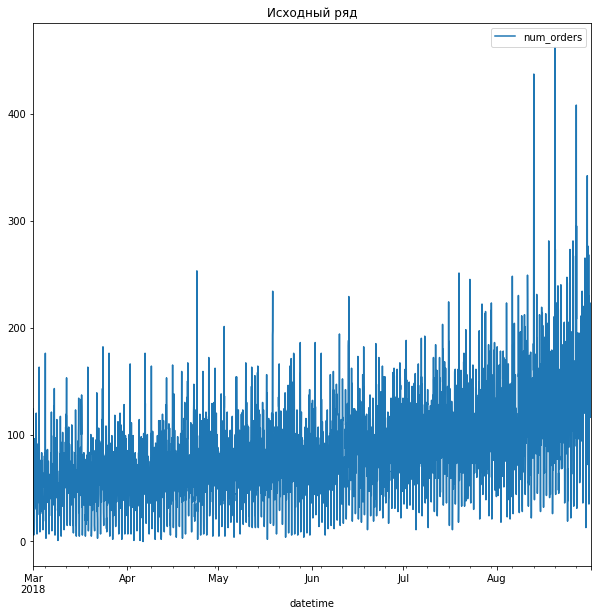

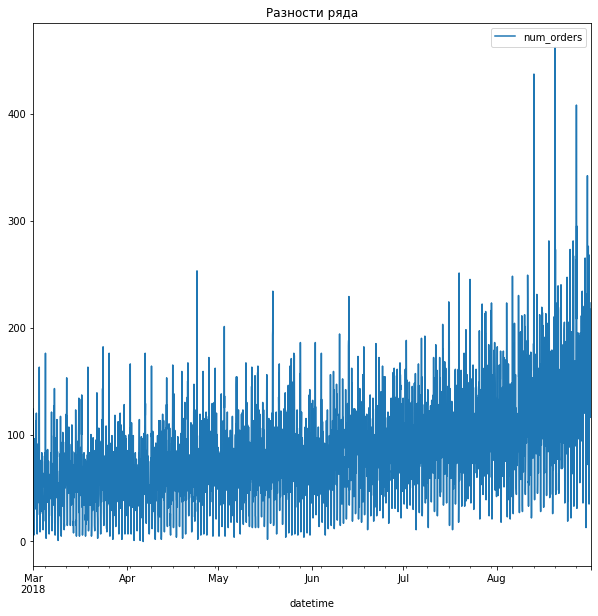

In [99]:
# найдем разности временного ряда
analysis.plot(figsize=(10,10))
plt.title('Исходный ряд')
plt.show()

analysis.shift(fill_value=0).plot(figsize=(10,10))
plt.title('Разности ряда')
plt.show()

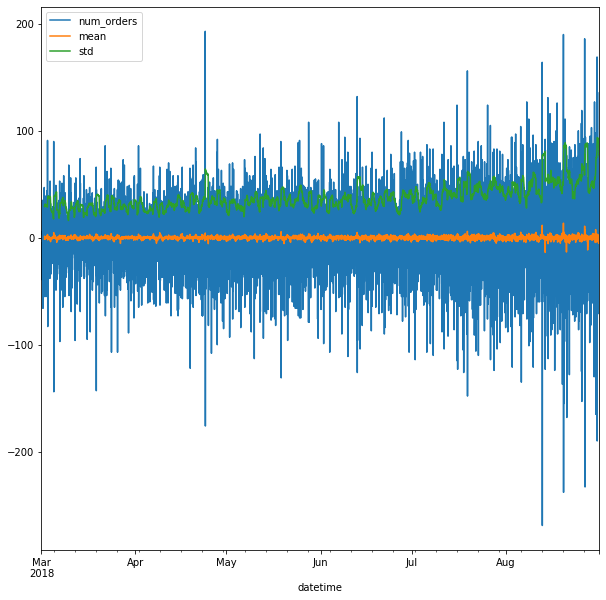

In [100]:
# построим среднюю, стандартное отклонение на графике разности временного ряда
analysis = analysis - analysis.shift()
analysis['mean'] = analysis['num_orders'].rolling(24).mean()
analysis['std'] = analysis['num_orders'].rolling(24).std()
analysis.plot(figsize=(10,10))
plt.show()

In [101]:
data = data.drop('rolling_mean', axis=1)

### Вывод

По итогам рассмотрения временного ряда выявили следующие черты:
1. На графике есть тренд, тренд растущий, ближе к зимнему периоду количество заказов растет;
2. Есть определенная цикличность, но сезонность оценить проблематично, т.к. данные имеются только за 6 месяцев,
3. График остатков имеет линейный характер в диапазоне от 20 до -20 с редкими выбросами,
4. Циклический ряд стационарный, т.е. распределение со временем не изменяется,
5. Разности временного ряда стационарны, выше показано, что ряды практически идентичны, поэтому скорее стационарны и имеют линейный характер.

## Обучение моделей

In [102]:
# создадим признаки
def make_features(data, max_lag, rolling_mean_size):
    data['weekday'] = data.index.weekday
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
make_features(data,2,24)
display(data.head(30))

,num_orders,weekday,hour,lag_1,lag_2,rolling_mean
datetime,,,,,,
2018-03-01 00:00:00,124,3,0,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,124.0,NaN,NaN
2018-03-01 02:00:00,71,3,2,85.0,124.0,NaN
2018-03-01 03:00:00,66,3,3,71.0,85.0,NaN
2018-03-01 04:00:00,43,3,4,66.0,71.0,NaN
2018-03-01 05:00:00,6,3,5,43.0,66.0,NaN
2018-03-01 06:00:00,12,3,6,6.0,43.0,NaN
2018-03-01 07:00:00,15,3,7,12.0,6.0,NaN
2018-03-01 08:00:00,34,3,8,15.0,12.0,NaN


In [103]:
# исключим пустые значения в данных по лагам и скользящему среднему, объем исключаемых данных несущественен - 1 сутки
data = data['2018-03-02':'2018-08-31']

In [104]:
# разделим данные
target = data['num_orders']
features = data.drop('num_orders', axis=1)
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle=False, test_size=0.1, random_state=654321)

display(features_train.shape)
display(features_test.shape)
display(target_train.shape)
display(target_test.shape)

(3952, 5)

(440, 5)

(3952,)

(440,)

In [105]:
# проверим на корреткность деления
display(features_train.index.min(), features_train.index.max())
display(features_test.index.min(), features_test.index.max())

Timestamp('2018-03-02 00:00:00', freq='H')

Timestamp('2018-08-13 15:00:00', freq='H')

Timestamp('2018-08-13 16:00:00', freq='H')

Timestamp('2018-08-31 23:00:00', freq='H')

In [106]:
# подготовка к кроссвалидации на временном ряду
tscv = TimeSeriesSplit(n_splits=10)

### Работа с LinearRegression

In [107]:
%%time
# кроссвалидация на модели LinearRegression
lr = LinearRegression()
scores = []
scores = cross_val_score(lr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('Средняя RMSE модели LinearRegression на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели LinearRegression на обучающей выборке: 31.195070465871943
CPU times: total: 203 ms
Wall time: 49 ms


### Работа с RandomForestRegressor

In [108]:
%%time
# получим лучшие параметры для RandomForestRegressor
params = { 'n_estimators': [10, 30, 60, 80, 100, 200],
              'max_depth': [None, 1, 3, 10, 20, 40, 80], 
         'random_state': [654321]}
rfr = RandomForestRegressor()
grid_rfr = GridSearchCV(rfr, params, cv=tscv)
grid_rfr.fit(features_train, target_train)
display(grid_rfr.best_params_)

{'max_depth': None, 'n_estimators': 200, 'random_state': 654321}

CPU times: total: 2min 4s
Wall time: 2min 4s


In [109]:
%%time
# кроссвалидация на модели RandomForestRegressor
rfr = RandomForestRegressor(random_state=654321, n_estimators=200, max_depth=None)
scores = []
scores = cross_val_score(rfr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('Средняя RMSE модели RandomForestRegressor на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели RandomForestRegressor на обучающей выборке: 24.136166535437603
CPU times: total: 9.45 s
Wall time: 9.45 s


### Работа с DecisionTreeRegressor

In [110]:
%%time
# получим лучшие параметры для DecisionTreeRegressor
params = { 'max_features': [2, 4, 6, 10, 20],
              'max_depth': [None, 1, 3, 10, 50, 100], 
         'random_state': [654321]}
dtr = DecisionTreeRegressor()
grid_dtr = GridSearchCV(dtr, params, cv=tscv)
grid_dtr.fit(features_train, target_train)
display(grid_dtr.best_params_)

{'max_depth': 10, 'max_features': 4, 'random_state': 654321}

CPU times: total: 1.36 s
Wall time: 1.35 s


In [111]:
%%time
# кроссвалидация на модели DecisionTreeRegressor
dtr = DecisionTreeRegressor(random_state=654321, max_depth=10, max_features=4)
scores = []
scores = cross_val_score(dtr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error')
print('Средняя RMSE модели DecisionTreeRegressor на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели DecisionTreeRegressor на обучающей выборке: 29.37808844566021
CPU times: total: 93.8 ms
Wall time: 75 ms


### Работа с LightGBM

In [112]:
%%time
# получим лучшие параметры для LGBMRegressor
params = { 'max_depth': [None, 1, 3, 10, 100, 200],
          'n_estimators': [5, 50, 100, 150, 500],
         'random_state': [654321],
         'num_leaves': [10,30,60,80],
         'learning_rate':[0.01, 0.05, 0.07, 1]}
lgbmr = LGBMRegressor(objective='regression')
grid_lgbmr = GridSearchCV(lgbmr, params, cv=tscv)
grid_lgbmr.fit(features_train, target_train)
display(grid_lgbmr.best_params_)

{'learning_rate': 0.01,
 'max_depth': 10,
 'n_estimators': 500,
 'num_leaves': 60,
 'random_state': 654321}

CPU times: total: 1h 5min 14s
Wall time: 5min 49s


In [113]:
%%time
# кроссвалидация на модели LGBMRegressor
lgbmr = LGBMRegressor(objective='regression',num_leaves=60,learning_rate=0.01,n_estimators=500, max_depth=10, random_state=654321)
scores = []
scores = cross_val_score(lgbmr, features_train, target_train, cv=tscv, scoring='neg_root_mean_squared_error', n_jobs=-1, error_score='raise')
print('Средняя RMSE модели LGBMRegressor на обучающей выборке:', scores.mean()*-1)

Средняя RMSE модели LGBMRegressor на обучающей выборке: 23.86346438781704
CPU times: total: 891 ms
Wall time: 17.9 s


## Тестирование моделей

### Тест LinearRegression

In [114]:
%%time
# получим RMSE для модели LinearRegression
lr.fit(features_train, target_train)
predictions_test = lr.predict(features_test)
print('RMSE модели LinearRegression на тестовой выборке:', math.sqrt(mean_squared_error(target_test, predictions_test)))

RMSE модели LinearRegression на тестовой выборке: 51.29636818907293
CPU times: total: 0 ns
Wall time: 6 ms


### Тест RandomForestRegressor

In [115]:
%%time
# получим RMSE для модели RandomForestRegressor
rfr.fit(features_train, target_train)
predictions_test = rfr.predict(features_test)
print('RMSE модели RandomForestRegressor на тестовой выборке:', math.sqrt(mean_squared_error(target_test, predictions_test)))

RMSE модели RandomForestRegressor на тестовой выборке: 46.5445158728814
CPU times: total: 2.69 s
Wall time: 1.8 s


### Тест DecisionTreeRegressor

In [116]:
%%time
# получим RMSE для модели DecisionTreeRegressor
dtr.fit(features_train, target_train)
predictions_valid = dtr.predict(features_test)
print('RMSE модели DecisionTreeRegressor на тестовой выборке:', math.sqrt(mean_squared_error(target_test, predictions_test)))

RMSE модели DecisionTreeRegressor на тестовой выборке: 46.5445158728814
CPU times: total: 0 ns
Wall time: 13 ms


### Тест LightGBM

In [117]:
%%time
# получим RMSE для модели LGBMRegressor
lgbmr.fit(features_train, target_train)
predictions_test = lgbmr.predict(features_test)
print('RMSE модели LGBMRegressor на тестовой выборке:', math.sqrt(mean_squared_error(target_test, predictions_test)))

RMSE модели LGBMRegressor на тестовой выборке: 44.08969646120965
CPU times: total: 5.05 s
Wall time: 472 ms


## Вывод

In [132]:
# сформируем сводную таблицу для оценки результатов
pivot_data_models = {'Model': ['LinearRegression базовая', 'RandomForestRegressor c подобранными параметрами', 'DecisionTreeRegressor c подобранными параметрами', 'LGBMRegressor с подобранными параметрами'],
                   'RMSE cross val score на обучающей выборке': [31.195070465871943, 24.136166535437603, 29.37808844566021, 23.86346438781704],
                   'Wall time CVS': ['49 ms', '9.45 s', '75 ms', '17.9 s'],
                   'RMSE на тестовой выборке': [51.29636818907293, 46.5445158728814, 46.5445158728814, 44.08969646120965],
                   'Wall time test': ['6 ms', '1.8 s', '13 ms', '472 ms']}
pivot_data_models = pd.DataFrame(pivot_data_models)
display(pivot_data_models.sort_values('RMSE на тестовой выборке', ascending=True))

,Model,RMSE cross val score на обучающей выборке,Wall time CVS,RMSE на тестовой выборке,Wall time test
3,LGBMRegressor с подобранными параметрами,23.863464,17.9 s,44.089696,472 ms
1,RandomForestRegressor c подобранными параметрами,24.136167,9.45 s,46.544516,1.8 s
2,DecisionTreeRegressor c подобранными параметрами,29.378088,75 ms,46.544516,13 ms
0,LinearRegression базовая,31.195070,49 ms,51.296368,6 ms


In [119]:
# сформируем датасет для построения графика
target_test = pd.DataFrame(target_test)
target_test['predictions'] = predictions_test
target_test.columns = ['real_data', 'predictions']
target_test.head(100)

,real_data,predictions
datetime,,
2018-08-13 16:00:00,144,150.128391
2018-08-13 17:00:00,152,129.662666
2018-08-13 18:00:00,104,98.567753
2018-08-13 19:00:00,91,97.778766
2018-08-13 20:00:00,82,97.144484
2018-08-13 21:00:00,160,112.171130
2018-08-13 22:00:00,104,124.208078
2018-08-13 23:00:00,134,111.009733
2018-08-14 00:00:00,139,191.288304


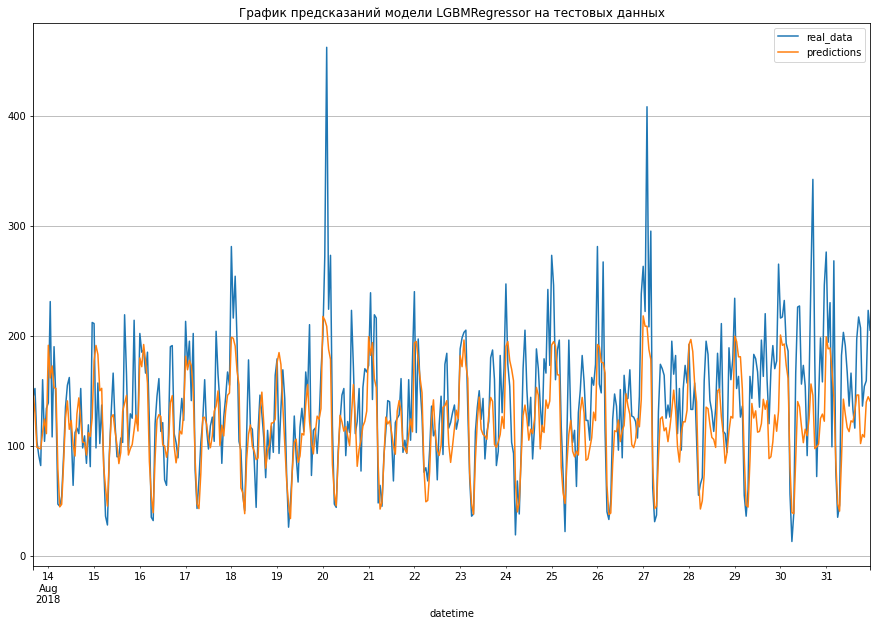

In [126]:
# сформирован график предсказаний модели LGBMRegressor на тестовых данных
target_test.plot(figsize=(15,10))
plt.title('График предсказаний модели LGBMRegressor на тестовых данных')
plt.legend(loc='best')
plt.grid(True)
plt.show()

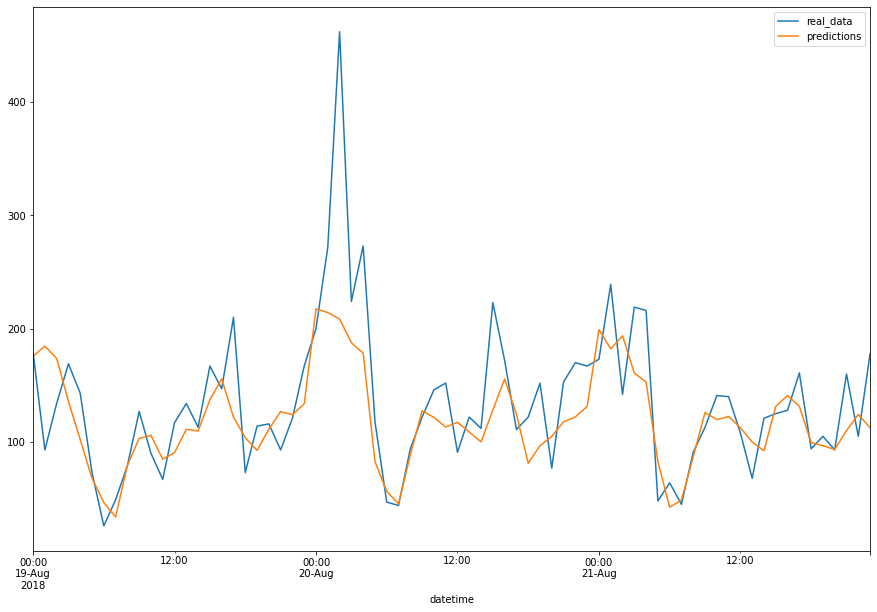

In [131]:
# сформирован почасовой график для отображения одного из экстремумов
target_test['2018-08-19':'2018-08-21'].plot(ax=plt.gca(), figsize=(15,10))
plt.show()

Проанализировав и протестировав 4 модели было выяснено, что наименьшее RMSE у модели LGBMRegressor, она предугадывает точнее и быстрее относительно RandomForestRegressor, однако другие простые модели дали чуть более худший результат и разрыв между ними минимален. Исследование подтверждает, что в рамках метрики RMSE 3 из 4 моделей, базовая линейная регрессия повела себя несколько хуже. Графики предсказаний лучшей выбранной модели LGBMRegressor отображены выше, на них также отображены некоторые экстремум по часам, которые показывают, что модель предсказывает с приемлемым качеством, однако не все экстремумы отлавливает.